# CS596 Machine Learning 
# Assignment 7 (Part 2): <br>Build a Convolutional Neural Network Model for Image Classification using PyTorch

### Due 11:59 pm, Friday, 11/13/2020

**Total points: 8**

In Part 2 of Assignment 7, you will implement a fully functioning CNN model using PyTorch. You will use the model to conduct image classification on the sign language dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import importlib
importlib.reload(utils)

# PyTorch is needed for this assignment
# You can install it following the instructions on the official website: https://pytorch.org/get-started/locally/
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

%matplotlib inline
np.random.seed(1)

## Load data

Load the sign language dataset.

X_train.shape: (1644, 1, 64, 64)
Y_train.shape: (1644,)
X_test.shape: (418, 1, 64, 64)
Y_test.shape: (418,)


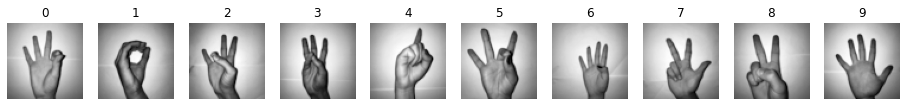

In [2]:
# Load data
X_train, Y_train, X_test, Y_test = utils.load_data()

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

# Visualize some data
fig = plt.figure(figsize=(16, 8))
for i in range(10):
    img = X_train[180*i,:].reshape((64,64))
    fig.add_subplot(1, 10, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    y_label = Y_train[180*i]
    plt.title(y_label)
plt.show()

***

## Task 1 Define the model
**5 points**

You will need to define your CNN model as a subclass of `torch.nn.Module`. Becuase we have already imported `torch.nn` as `nn`, we can specify the baseclass simply as `nn.Module`. 

You need to override two functions in defining the class, `__init__()` and `forward()`.
- All the parameters, including the convolutional, pooling, and fully-connected layers are defined in `__init__()`. They are declared and initialized as members of the class, using the `self.` notation in Python. 
- The forward pass of the computational graph is defined in `forward()`. This function takes as input the training data, and call all operations (conv, pool, etc.) sequentially on the data. The output of a preceding operation is used as the input for the following operation. 

**Instructions:**

- Define the model so that the architecture is as follows: <br>
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED_1 -> FULLYCONNECTED_2 -> SOFTMAX.

- *Note* that the *RELU* and *FLATTEN* functions are defined in `forward()` rather than `__init__()`.

- The `in_features` of `self.fc1` is the total number of output units after the `self.pool2` layer. This can be computed using the formula in the slides:
\begin{equation}\text{Output} = (\lfloor\frac{n+2p-f}{s}\rfloor + 1)\times(\lfloor\frac{n+2p-f}{s}\rfloor + 1)\end{equation}

In [3]:
infeat = 0
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        
        # The first convolutional layer has in_channels=1, out_channels=6, kernel_size=3, with default stride=1 and padding=0
        self.conv1 = nn.Conv2d(1, 6, 3)
        no1 = int(((64+2*0-3)/1)+1)
        # The first pooling layer is a maxpool with a square window of kernel_size=2 (default stride is same as kernel_size)
        self.pool1 = nn.MaxPool2d(2)
        no1p = int(((no1+2*0-2)/2)+1)
        ### START YOUR CODE ###
        # The second convolutional layer's in_channels should match the out_channels of conv1
        # Hint: Replace the "None" with the correct number
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5, stride=2)
        no2 = int(((no1p+2*0-5)/2)+1)
        # The second pooling layer has the same setting as pool1
        self.pool2 = nn.MaxPool2d(2)
        no2p = int(((no2+2*0-2)/2)+1)
        
        # The first fully-connected layer
        # Hint: Use nn.Linear, and replace the "None" with the correct number for the in_features
        global infeat
        infeat = (no2p**2)*12
        #print('nFeat:{0}'.format(infeatd))
        self.fc1 = nn.Linear(infeat, 100)
        ### END YOUR CODE ###
        
        # Second fully-connected layer
        self.fc2 = nn.Linear(100, 10)
        
        # Softmax layer
        self.output = nn.LogSoftmax(dim=1)
        
    
    def forward(self, x):
        # Conv1 -> ReLU -> Pool1
        x = self.pool1(F.relu(self.conv1(x)))
        
        ### START YOUR CODE ###
        # Conv2 -> ReLU -> Pool2
        # Hint: Follow the line of code above
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the output from the last pooling layer
        # Hint: Replace "None" with the correct number (same as the in_features of fc1)
        x = x.view(-1, infeat)
        ### END YOUR CODE ###
        
        # Call two fully-connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Call softmax layer
        x = self.output(x)
        
        return x

In [4]:
# Evaluate Task 1
model = CNN_Model()

torch.manual_seed(0)
input_data = torch.randn(20, 1, 64, 64)
output = model(input_data)

print('output.size():', output.size())
print('output.sum()', output.sum().item())

output.size(): torch.Size([20, 10])
output.sum() -460.8240661621094


### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**output.size():**| torch.Size([20, 10])|
|**output.sum():**| -460.79412841796875|

***

## Task 2 Train and evaluation
**3 points**

Now you will use the functions you have implemented above to build a full model. Then you train the model on the sign language dataset.

You can refer to the official website of PyTorch (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for information about how to use optimizers, computing loss, and carrying out backprop etc.


In [5]:
def run(model, X_train, Y_train, X_test, Y_test, learning_rate=0.01,
          num_epochs=100, minibatch_size=8, print_cost=True):
    """
    Args:
    X_train -- training set, of shape (m, 1, 64, 64), in which m is the number of training examples
    Y_train -- test set, of shape (m, 10)
    X_test -- training set, of shape (m', 1, 64, 64)
    Y_test -- test set, of shape (m', 10)
    learning_rate -- learning rate 
    num_epochs -- number of epochs
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 5 epochs
    """
    
    seed = 0                                         # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape                                  
    costs = []                                       # To keep track of the cost
    
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
     
    # Training loop
    model.train() # Turn on the training mode
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
        seed = seed + 1
        minibatches = utils.generate_minibatch(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:
            (batch_x, batch_y) = minibatch
            data_x = torch.Tensor(batch_x)
            data_y = torch.LongTensor(batch_y)
            
            ### START YOUR CODE ### 
            # Zero the gradients
            optimizer.zero_grad() # Hint: call zero_grad()
            
            # Forward pass and compute loss
            outputs = model(data_x) # Hint: use model as a callable
            loss = criterion(outputs, data_y) # Hint: use criterion as a callable
            
            # Backward and optimize
            loss.backward() # Hint: call backward()
            optimizer.step() # Hint: call step()
            ### END YOUR CODE ###
            
            minibatch_cost += loss.item()
        
        # Print the cost every epoch
        minibatch_cost /= num_minibatches
        if print_cost and epoch % 5 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
        costs.append(minibatch_cost)
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()

    # Calculate accuracy on the train and test datasets
    data_x = torch.Tensor(X_test)
    data_y = torch.LongTensor(Y_test)
    model.eval() # Turn on the evaluation mode
    with torch.no_grad():
        test_pred = model(data_x)
        num_correct = (torch.argmax(test_pred, dim=1).view(data_y.size()).data == data_y.data).float().sum()
        test_acc = (num_correct / test_pred.size()[0]) * 100
    print("Test Accuracy:", test_acc.item())

Cost after epoch 0: 2.314474
Cost after epoch 5: 2.313698
Cost after epoch 10: 2.313136
Cost after epoch 15: 2.312216
Cost after epoch 20: 2.309961
Cost after epoch 25: 2.299331
Cost after epoch 30: 2.227358
Cost after epoch 35: 1.272510
Cost after epoch 40: 0.824895
Cost after epoch 45: 0.703970
Cost after epoch 50: 0.630388
Cost after epoch 55: 0.581295
Cost after epoch 60: 0.557049
Cost after epoch 65: 0.538915
Cost after epoch 70: 0.530069
Cost after epoch 75: 0.523268
Cost after epoch 80: 0.524887
Cost after epoch 85: 0.522816
Cost after epoch 90: 0.521105
Cost after epoch 95: 0.522077


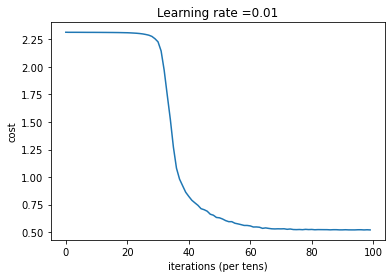

Test Accuracy: 72.96650695800781


In [6]:
# Evaluate Task 2
model = CNN_Model()

torch.manual_seed(0)
run(model, X_train, Y_train, X_test, Y_test)

# NOTE: It could be slow to run 100 epochs. Make sure that your costs for after each epoch  
# are the same as those in the expected output. If yours are different, click the stop button
# on the menu bar and then check your code.

### Expected output

|&nbsp;|&nbsp; |          
|--|--|
|**Cost after epoch 0:**| 2.313738|
|**Cost after epoch 5:**| 2.310775|
|**Cost after epoch 10:**| 2.290986|
|...|...|
|**Cost after epoch 85:**| 0.002756|
|**Cost after epoch 90:**| 0.002577|
|**Cost after epoch 95:**| 0.002472|


The performance varies each time you run the model.
Roughly speaking, you should get a **test accuracy** around **90%** (Even above when you are lucky).

***

## Congratulations!
Now you have successfully built a convolutional neural network model for image classification! 
Hopefully this experience of using PyTorch will help you with your term project.